## 0. Entendendo os dados originais da Rossmann


##### **0. store**:
- um ID exclusivo para cada loja

##### **1. day_of_week**:
- dia da semana em que a venda ocorreu (dados não descritos)

##### **2. date**:
- data de venda (dados não descritos)

##### **3. sales**:
- o volume de negócios para um determinado dia (isto é o que você está prevendo) 

##### **4. customers**:
- o número de clientes em um determinado dia  

##### **5. open**: 
- um indicador para saber se a loja estava aberta: 0 = fechado, 1 = aberto  

##### **6.  promo**:
- indica se uma loja está realizando uma promoção naquele dia

##### **7. state_holiday**:
- indica um feriado estadual. Normalmente todas as lojas, com poucas exceções, fecham nos feriados estaduais. Observe que todas as escolas fecham nos feriados e fins de semana. a = feriado, b = feriado da Páscoa, c = Natal, 0 = nenhum

##### **8. school_holiday**:
- indica se o (store, date) foi afetado pelo fechamento das escolas públicas

##### **9. store_type**:
- diferencia entre 4 modelos de loja diferentes: a, b, c, d

##### **10. assortment**: 
- descreve um nível de sortimento (tipo de produto que tem na loja): a = básico, b = extra, c = estendido

##### **11. competition_distance**:
- distância em metros até a loja concorrente mais próxima

##### **12. competition_open_since_month**:
- fornece o mês aproximado em que o concorrente mais próximo foi aberto

##### **13. competition_open_since_year**:
- fornece o ano aproximado em que o concorrente mais próximo foi aberto

##### **14 . promo2**:
- promo2 é uma promoção contínua e consecutiva para algumas lojas: 0 = a loja não está participando, 1 = a loja está participando

##### **15. promo2_since_week**:
- descreve a semana em que a loja começou a participar da 'promo2'

##### **16. promo2_since_year**:
- descreve o ano em que a loja começou a participar da 'promo2'

##### **17.  promo_interval**:
- meses em que a promo2 ficou ativa

## 1. Bibliotecas

In [6]:
import pandas as pd
import numpy as np
import inflection
import math
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import Image
import datetime
from tabulate import tabulate
from scipy import stats as stats
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor

## 2. Funções auxiliares

In [7]:
# Cramer V para calcular a correlação de dados categóricos

def cramer_v(x, y):
    confusion_matrix = pd.crosstab(x, y).to_numpy()
    n = confusion_matrix.sum()
    r, k = confusion_matrix.shape

    chi2 = stats.chi2_contingency(confusion_matrix)[0]

    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))

    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)

    return np.sqrt((chi2/n)/(min(k-1, r-1)))

## 3. Carregamento dos dados

In [8]:
df_sales_raw = pd.read_csv('datasets/train.csv', low_memory=False)
df_store_raw = pd.read_csv('datasets/store.csv', low_memory=False)

# merge (unindo os arquivos csv)
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

## 4. Descrição dos dados

### 4.1. Renomeando colunas

In [9]:
# criando uma cópia do dataset para trabalhar com os dados
df1 = df_raw.copy()

In [10]:
# nomes das colunas antigas
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [11]:
cols_originais = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday',
                  'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
                  'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']


# criando função para modificar os nomes
def snakecase(x):
    return inflection.underscore(x)


# salvando colunas novas e aplicando a função anterior utilizando o map
cols_novas = list(map(snakecase, cols_originais))

# renomeando
df1.columns = cols_novas

In [12]:
# checar modificação nos nomes das colunas

df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

In [13]:
df1.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


### 4.2. Verificando a dimensão dos dados

In [14]:
print(f'Linhas: {df1.shape[0]}')
print(f'Colunas: {df1.shape[1]}')

Linhas: 1017209
Colunas: 18


### 4.3. Verificando os tipos de dados

In [15]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [16]:
# coluna 'date' de object para datetime
df1['date'] = pd.to_datetime(df1['date'])

In [17]:
# checando modificações
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

### 4.4. Checando dados nulos (NA)

In [18]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

### 4.5. Entendendo e substituindo as colunas que possuem dados nulos

##### **comptetition_distance**:
- distância em metros do competidor mais próximo
- sugestão: substituir os dados nulos por um número acima do valor máximo de distância, pois ou não há competidor ou está longe o suficiente para não ser considerado um

##### **competition_open_since_month**:
- mês que o competidor mais próximo foi aberto
- sugestão: substituir os dados nulos do mês de abertura pelo mês da data de venda registrada (coluna 'date') na linha

##### **competition_open_since_year**:
- ano que o competidor mais pŕoximo foi aberto
- sugestão: substituir os dados nulos do ano de abertura pelo ano da data de venda registrada (coluna 'date') na linha

##### **OBSERVAÇÃO**:
- coluna promo2: significa continuação de uma promoção, 0 -  não está participando; 1- está participando
- as colunas seguintes dependem dessa
- importante: sempre onde a promo2 é 0, os dados seguintes são nulos, ou seja, apenas significam que não houve promo2

##### **promo2_since_week**:
- semana em que a loja começou a participar da promo2
- sugestão: substituir os dados nulos extraindo a semana da data de venda registrada (coluna 'date')

##### **promo2_since_year**:
- ano em que a loja começou a participar da promo2
- sugestão:substituir os dados nulos extraindo o ano da data de venda registrada (coluna 'date')

##### **promo_interval**:
- meses em que a promo2 ficou ativa

- sugestão 1: substituir dados nulos da 'promo_interval' por 0

- sugestão 2 ['month_map']: adicionar meses na coluna nova 'month_map' de acordo com o mês presente na coluna de data de venda 'date'

- sugestão 3 ['is_promo']: se o mês 'month_map' estiver dentro da lista presente em 'promo_interval', adicionar: 1-tem promoção; 0-não tem promoção.

In [19]:
# visualização da matriz transposta

df1.T

,0,1,2,3,4,5,6,7,8,9,...,1017199,1017200,1017201,1017202,1017203,1017204,1017205,1017206,1017207,1017208
store,1,2,3,4,5,6,7,8,9,10,...,1106,1107,1108,1109,1110,1111,1112,1113,1114,1115
day_of_week,5,5,5,5,5,5,5,5,5,5,...,2,2,2,2,2,2,2,2,2,2
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,...,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00
sales,5263,6064,8314,13995,4822,5651,15344,8492,8565,7185,...,0,0,0,0,0,0,0,0,0,0
customers,555,625,821,1498,559,589,1414,833,687,681,...,0,0,0,0,0,0,0,0,0,0
open,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
promo,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
state_holiday,0,0,0,0,0,0,0,0,0,0,...,a,a,a,a,a,a,a,a,a,a
school_holiday,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
store_type,c,a,a,c,a,a,a,a,a,a,...,a,a,a,c,c,a,c,a,a,d


In [20]:
# encontrando o valor máximo para utilizar de parâmetro para a 'competition_distance'
df1['competition_distance'].max()

75860.0

In [21]:
# competition_distance

df1['competition_distance'] = df1['competition_distance'].apply(
    lambda x: 200000.0 if math.isnan(x) else x)

In [22]:
# competition_open_since_month

df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(
    x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

In [23]:
# competition_open_since_year

df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(
    x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

In [24]:
# promo2_since_week

df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(
    x['promo2_since_week']) else x['promo2_since_week'], axis=1)

In [25]:
# promo2_since_year

df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(
    x['promo2_since_year']) else x['promo2_since_year'], axis=1)

In [26]:
# promo_interval

# criar dicionario com os meses
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
             7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

# sugestão 1: se for nan, vai substituir por 0
df1['promo_interval'].fillna(0, inplace=True)

# sugestão 2: ['month_map']
df1['month_map'] = df1['date'].dt.month.map(month_map)

# sugestão 3: ['is_promo']
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(
    lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [27]:
# checando o tratamento de NA

df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

In [28]:
# checando os tipos de dados

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

### 4.6. Verificando e convertendo os tipos de dados

In [29]:
# convertendo colunas para int

df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(
    int)

df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(
    int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)

df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [30]:
# checando a conversão
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

### 4.7. Análises estatísticas

In [31]:
# separando colunas com dados numéricos
colunas_numericas = df1.select_dtypes(include=['int64', 'float64'])

# separando colunas com dados categóricos
colunas_categoricas = df1.select_dtypes(
    exclude=['int64', 'float64', 'datetime64[ns]'])

#### 4.7.1. Dados numéricos

In [32]:
# transpondo métricas de tendência central (média, mediana)

tc1 = pd.DataFrame(colunas_numericas.apply(np.mean)).T
tc2 = pd.DataFrame(colunas_numericas.apply(np.median)).T

# transpondo métricas de dispersãpo (desvio padrão, min, max, range, skew, kurtosis)

md1 = pd.DataFrame(colunas_numericas.apply(np.std)).T
md2 = pd.DataFrame(colunas_numericas.apply(min)).T
md3 = pd.DataFrame(colunas_numericas.apply(max)).T
md4 = pd.DataFrame(colunas_numericas.apply(lambda x: x.max() - x.min())).T
md5 = pd.DataFrame(colunas_numericas.apply(lambda x: x.skew())).T
md6 = pd.DataFrame(colunas_numericas.apply(lambda x: x.kurtosis())).T

# concatenando dados na ordem de visualização
metricas = pd.concat([md2, md3, md4, tc1, tc2, md1, md5, md6]).T.reset_index()

# nomeando colunas
metricas.columns = ['features', 'min', 'max', 'range',
                    'mean', 'median', 'std', 'skew', 'kurtosis']

# exibindo as métricas
metricas

,features,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


In [33]:
# selecionando o tema do gráfico
sns.set_theme(style='darkgrid')

<AxesSubplot: xlabel='competition_distance', ylabel='Count'>

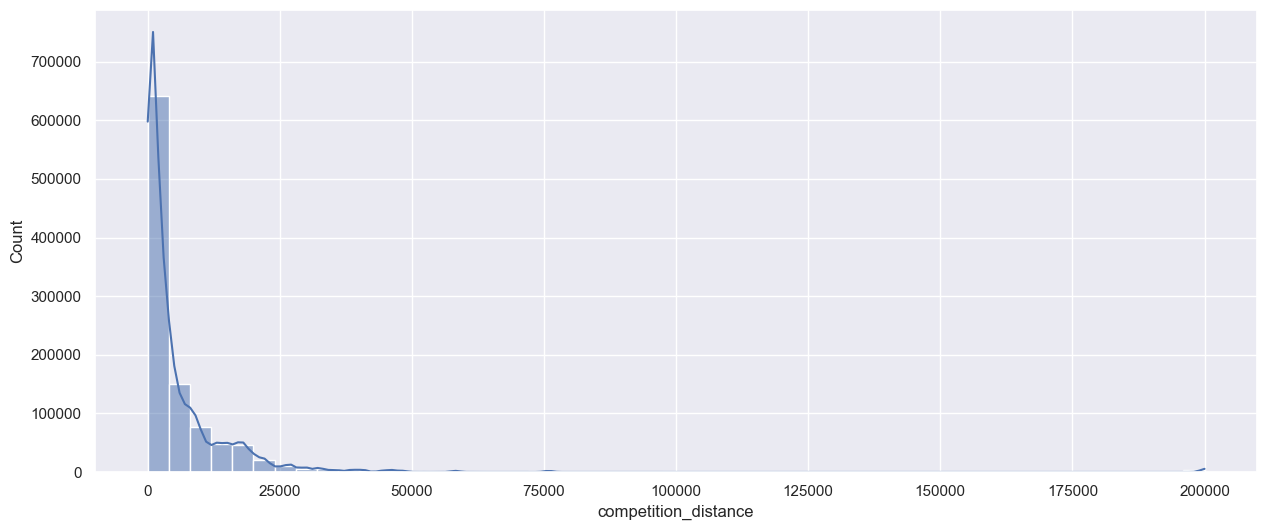

In [34]:
# verificando distribuição de distância dos concorrentes

plt.figure(figsize=(15, 6))
sns.histplot(df1['competition_distance'], bins=50, kde=True)

#### 4.7. 2. Dados categóricos

In [35]:
# valores únicos dos dados categóricos
colunas_categoricas.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot: xlabel='assortment', ylabel='sales'>

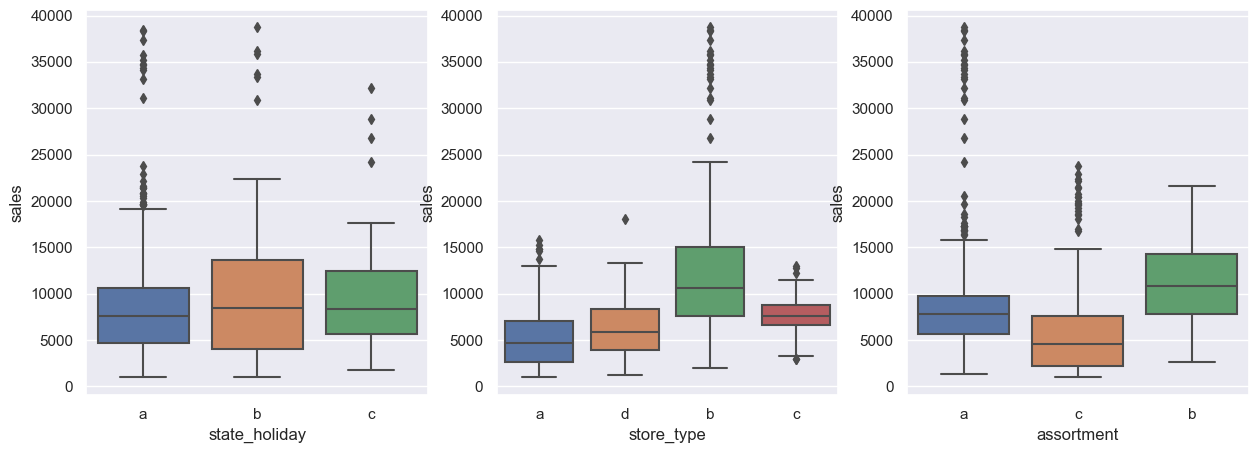

In [36]:
# criando um filtro de linhas
filtro = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

# noção das vendas distribuídas nos níveis das variáveis categóricas

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=filtro)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=filtro)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=filtro)

## 5. Detectando os agentes de impacto

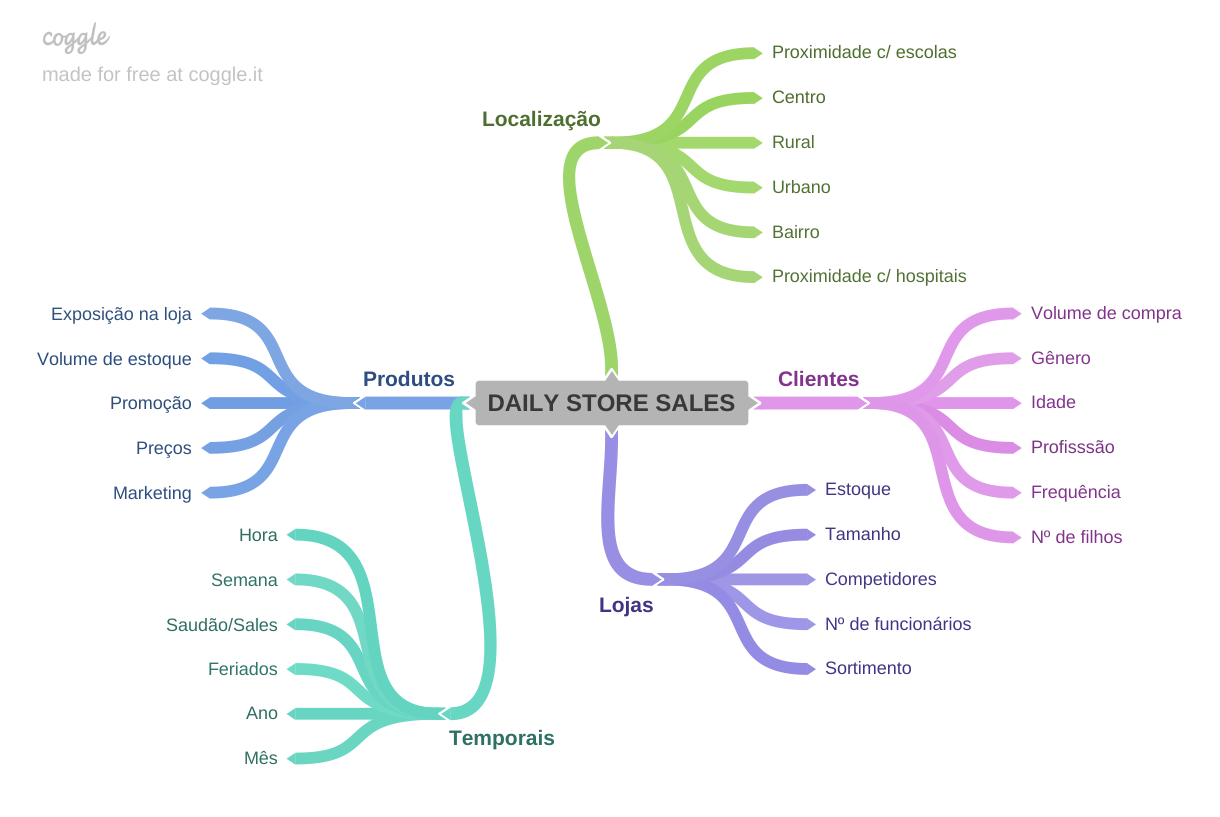

In [37]:
# Agentes de impacto nas vendas
Image("img/MindMapHypothesis.png")

## 6. Elaborando hipóteses

### 6.1. Hipóteses: Loja

**1.** Lojas com mais funcionários devem vender mais

**2.** Lojas com maior estoque devem vender mais

**3.** Lojas com maior porte devem vender mais

**4.** Lojas com maior sortimento devem vender mais

**5.** Lojas com competidores a mais tempo devem vender mais

### 6.2. Hipóteses: Produto

**1.** Lojas que investem mais em marketing devem vender mais

**2.** Lojas que expõem mais os produtos nas vitrines devem vender mais

**3.** Lojas que têm preços menores nos produtos devem vender mais

**4.** Lojas que têm preços menores por mais tempo nos produtos devem vender mais

**5.** Lojas com descontos maiores devem vender mais

**6.** Lojas com promoções ativas por mais tempo devem vender mais

**7.** Lojas com mais dias de promoção devem vender mais

**8.** Lojas com mais tipos de promoção consecutivas devem vender mais

### 6.3. Hipóteses: Tempo

**1.** Lojas que tem mais feriados devem vender menos

**2.** Lojas devem vender mais ao longo dos anos

**3.** Lojas devem vender mais no segundo semestre do ano

**4.** Lojas devem vender mais depois do dia 10 de cada mês

**5.** Lojas devem vender menos aos finais de semana

**6.** Lojas devem vender menos durante os feriados escolares

### 6.4. Lista final de hipóteses

**OBS:** foram priorizadas de acordo com o que possuía nos dados originais.

**1.** Lojas com maior sortimento devem vender mais
 
**2.** Lojas com competidores mais proximos devem vender menos
 
**3.** Lojas com competidores a mais tempo devem vender mais
 
**4.** Lojas com promoções ativas por mais tempo devem vender mais
 
**5.** Lojas com mais dias de promoção deveam vender mais
 
**6.** Lojas com mais promoções consecutivas devem vender mais
 
**7.** Lojas abertas durante o feriado de natal devem vender mais
 
**8.** Lojas devem vender mais ao longo dos anos
 
**9.** Lojas devem vender mais no segundo semestre do ano

**10.** Lojas devem vender mais depois do dia 10 de cada mês

**11.** Lojas devem vender menos nos finais de semana

**12.** Lojas devem vender menos durante os feriados escolares

## 7. Features engineering

### 7.1. Variáveis derivadas dos dados originais

In [38]:
# cópia do dataset
df2 = df1.copy()

In [39]:
# year
df2['year'] = df1['date'].dt.year

# month
df2['month'] = df1['date'].dt.month

# day
df2['day'] = df1['date'].dt.day

# week of year
df2['week_of_year'] = df1['date'].dt.isocalendar().week

# year week
df2['year_week'] = df1['date'].dt.strftime('%Y-%W')


# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'],
                                                                 month=x['competition_open_since_month'],
                                                                 day=1), axis=1)

df2['competition_time_month'] = (
    (df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype('int64')

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(
    str) + '-' + df2['promo2_since_week'].astype(str)

df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(
    x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))

df2['promo_time_week'] = (
    (df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days).astype('int64')

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else
                                                      'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else
                                                            'easter_holiday' if x == 'b' else
                                                            'chrismas' if x == 'c' else 'regular_day')

## 8. Filtragem de variáveis

In [40]:
# cópia do dataset
df3 = df2.copy()

### 8.1. Filtragem das linhas

In [41]:
# apenas linhas com a loja aberta e com as vendas maiores que zero
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

### 8.2. Filtragem das colunas

In [42]:
# deletando as colunas
drop_colunas = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(drop_colunas, axis=1)

In [43]:
# checando as colunas do dataset
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

## 9. Análise exploratória de dados

In [44]:
df4 = df3.copy()

### 9.1 Análise univariada

#### 9.1.1 Análise univariada da variável resposta

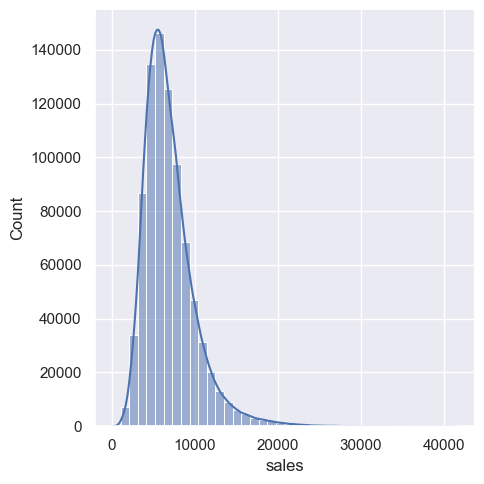

In [45]:
# distribuição da variável resposta

sns.displot(df4['sales'], bins=40, kde=True)

#### 9.1.2 Variáveis numéricas

array([[<AxesSubplot: title={'center': 'store'}>,
        <AxesSubplot: title={'center': 'day_of_week'}>,
        <AxesSubplot: title={'center': 'sales'}>,
        <AxesSubplot: title={'center': 'customers'}>],
       [<AxesSubplot: title={'center': 'open'}>,
        <AxesSubplot: title={'center': 'promo'}>,
        <AxesSubplot: title={'center': 'school_holiday'}>,
        <AxesSubplot: title={'center': 'competition_distance'}>],
       [<AxesSubplot: title={'center': 'competition_open_since_month'}>,
        <AxesSubplot: title={'center': 'competition_open_since_year'}>,
        <AxesSubplot: title={'center': 'promo2'}>,
        <AxesSubplot: title={'center': 'promo2_since_week'}>],
       [<AxesSubplot: title={'center': 'promo2_since_year'}>,
        <AxesSubplot: title={'center': 'is_promo'}>, <AxesSubplot: >,
        <AxesSubplot: >]], dtype=object)

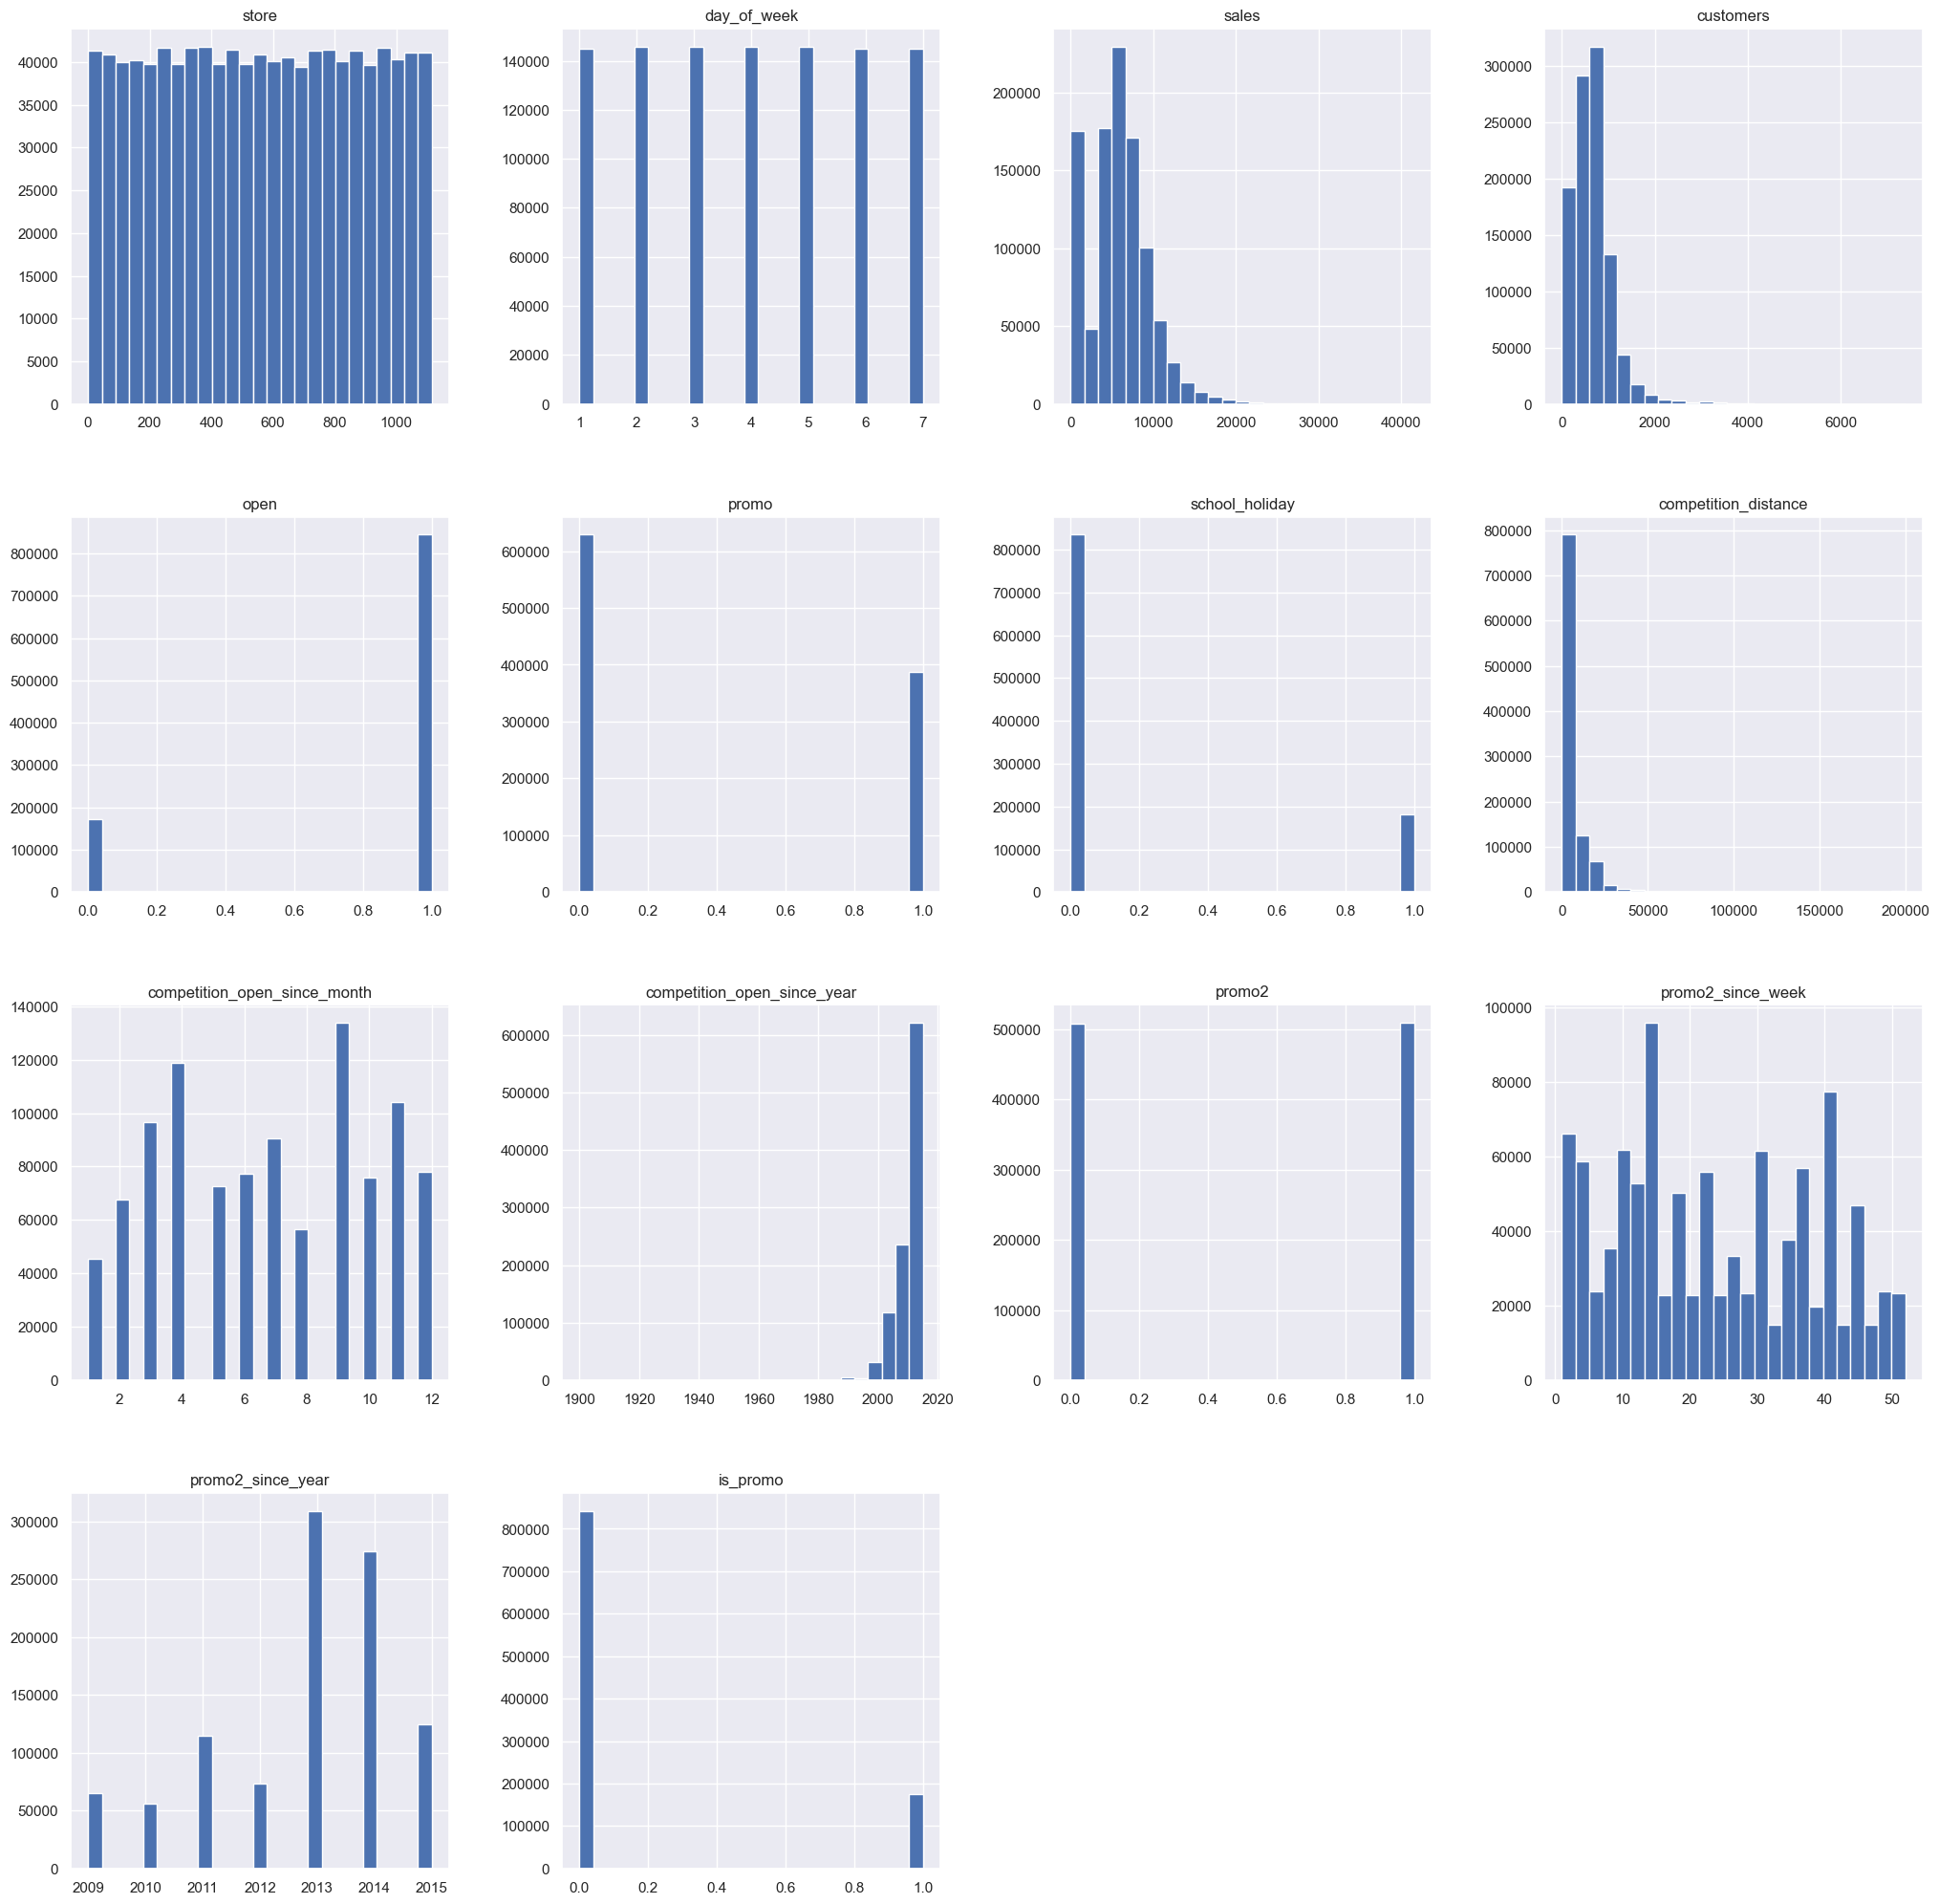

In [46]:
# checando as distribuições das variáveis numéricas

colunas_numericas.hist(figsize=(25, 25), bins=25)

##### Análise das variáveis numéricas

**competition_distance:**
- concentração maior de competidores na menor distância, ou seja, os competidores estão muito próximos

**competition_open_since_month:**
- os meses: 4, 9 e 11 foram os que mais abriram competidores próximos

**is_promo:**
- tem muito mais dias sem promoção


#### Variáveis sem variação:

- 'store'
- 'day_of_week'
- 'promo2'

#### 9.1.3 Variáveis categóricas

In [47]:
# checando categorias da coluna 'state_holiday'

df4['state_holiday'].unique()

array(['regular_day', 'public_holiday', 'easter_holiday', 'chrismas'],
      dtype=object)

In [48]:
# checando categorias da coluna 'story_type'

df4['store_type'].unique()

array(['c', 'a', 'd', 'b'], dtype=object)

In [49]:
# checando categorias da coluna 'story_type'

df4['assortment'].unique()

array(['basic', 'extended', 'extra'], dtype=object)

<AxesSubplot: xlabel='sales', ylabel='Density'>

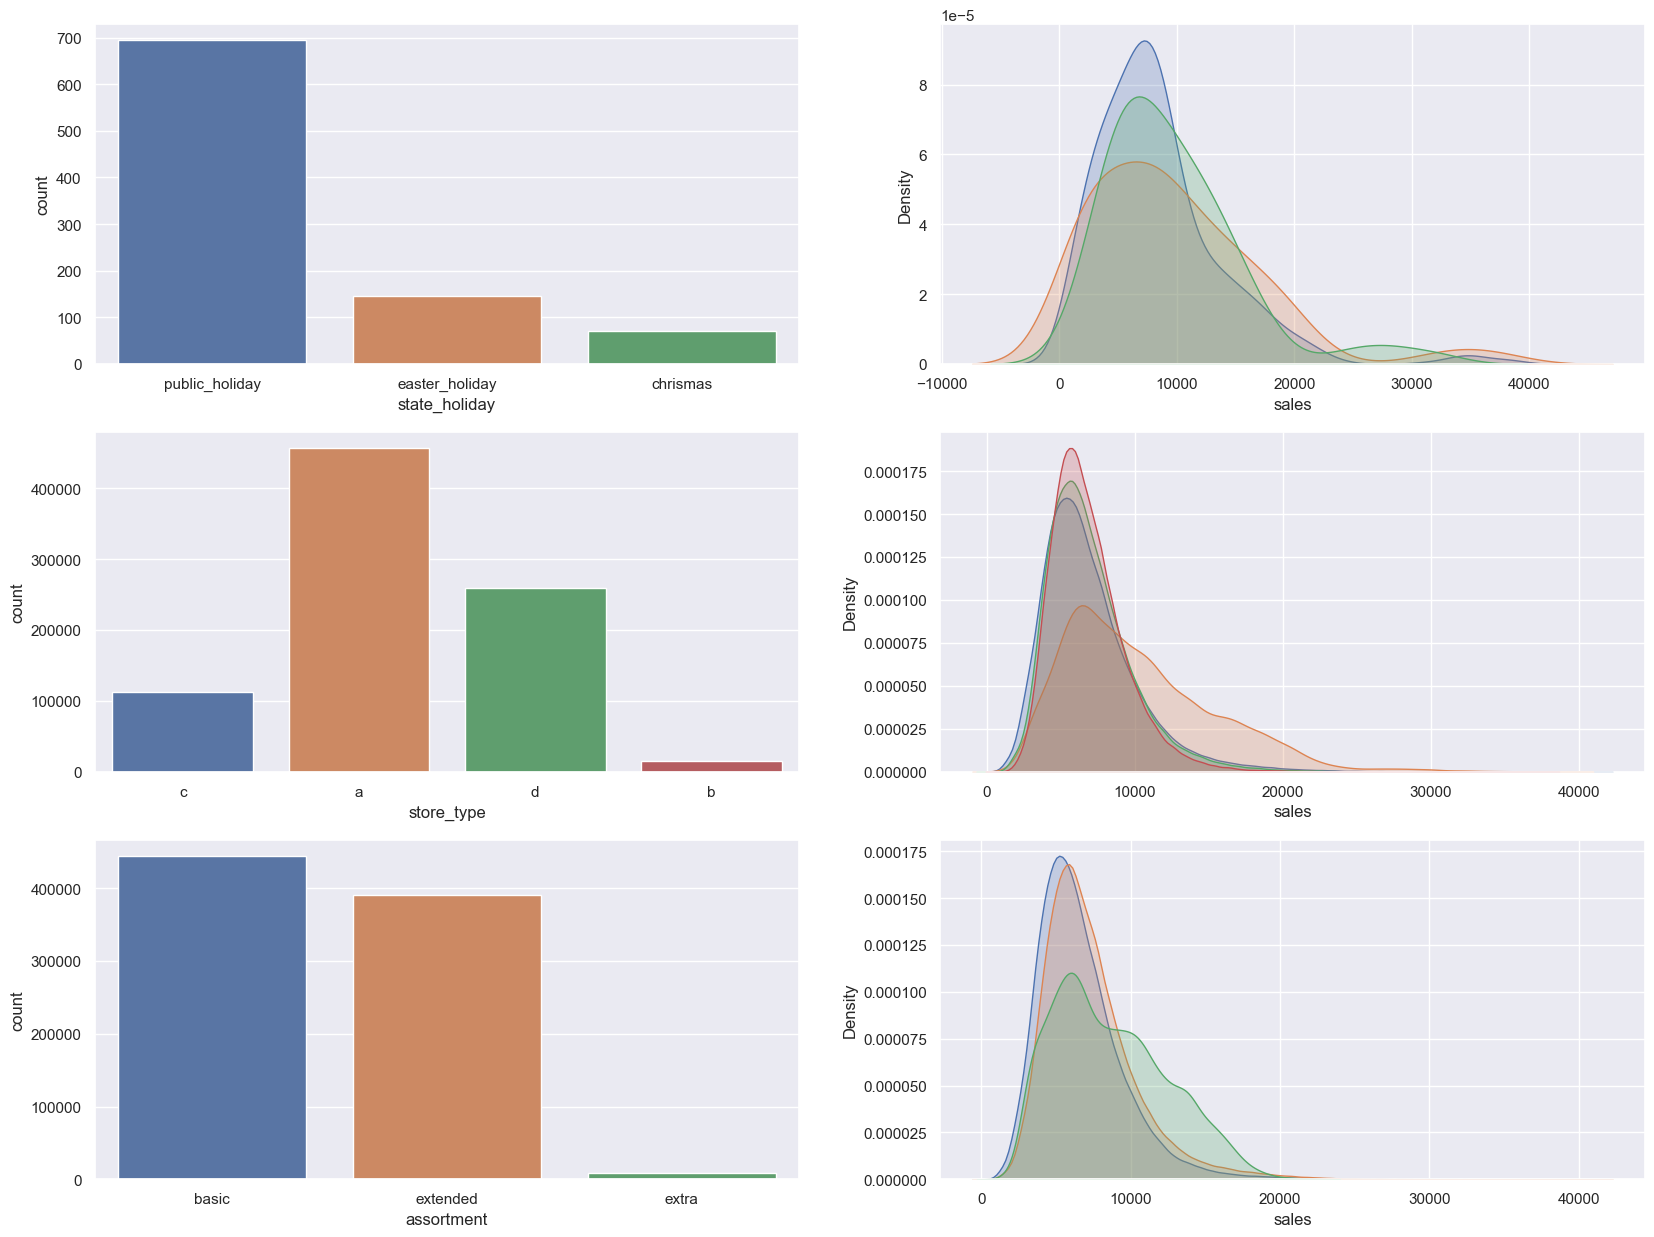

In [50]:
# 1. state_holiday

plt.figure(figsize=(20, 15))

plt.subplot(3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']  # filtro
sns.countplot(x='state_holiday', data=a)


plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'],
            label='public_holiday', fill=True)

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'],
            label='easter_holiday', fill=True)

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'chrismas']['sales'],
            label='chrismas', fill=True)

# 2. store_type

plt.subplot(3, 2, 3)
sns.countplot(x='store_type', data=df4)

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'],
            label='a', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'],
            label='b', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'],
            label='c', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'],
            label='d', fill=True)


# 3. assortment

plt.subplot(3, 2, 5)
sns.countplot(x='assortment', data=df4)

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'],
            label='basic', fill=True)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'],
            label='extended', fill=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'],
            label='extra', fill=True)

### 9.2 Análise bivariada

#### Hipótese 1: Lojas com maior sortimento devem vender mais

- **Hipótese Falsa** ❌
-  Lojas com maior sortimento vendem menos ✅

<AxesSubplot: xlabel='year_week'>

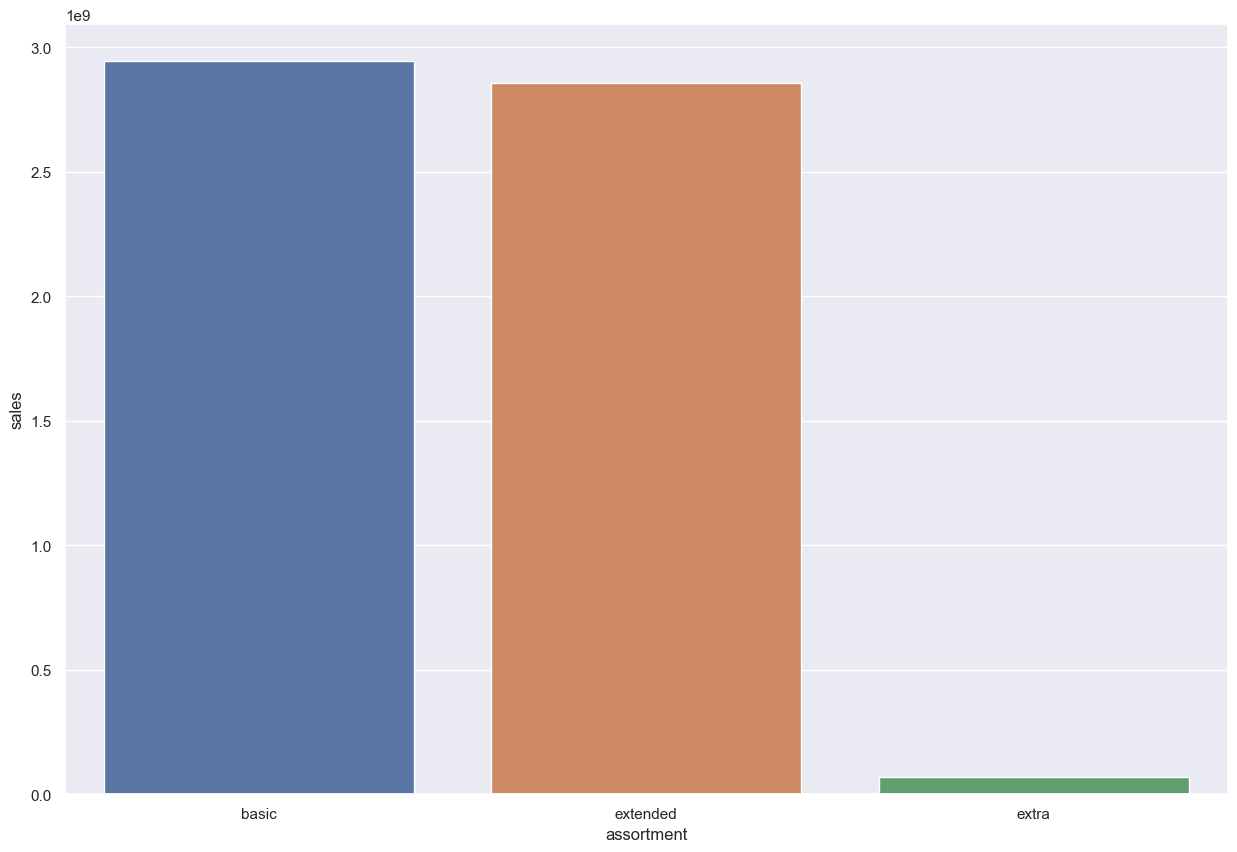

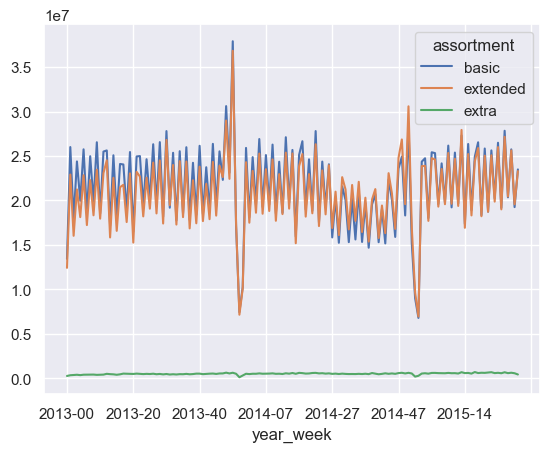

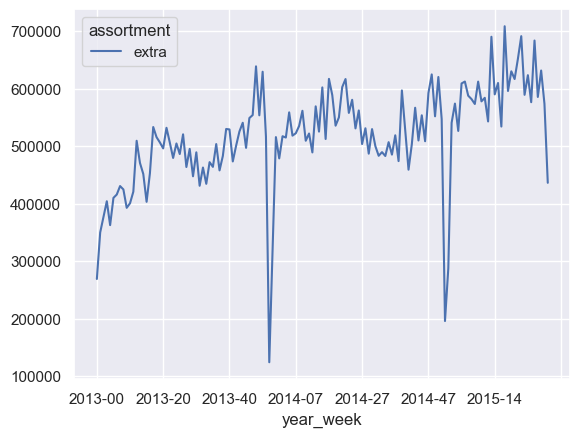

In [51]:
plt.figure(figsize=(15, 10))

# 1. comparando a soma das vendas por tipo de sortimento

aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1)


# 2. mostrando a variação das vendas por sortimento ao longo dos anos

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(
    ['year_week', 'assortment']).sum().reset_index()

aux2.pivot(index='year_week', columns='assortment', values='sales').plot()


# 3. mostrando variação das vendas quando o sortimento é 'extra'

aux3 = aux2[aux2['assortment'] == 'extra']  # maior sortimento
aux3.pivot(index='year_week', columns='assortment', values='sales').plot()

#### Hipótese 2: Lojas com competidores mais proximos devem vender menos

- **Hipótese Falsa** ❌
- Lojas com competidores mais próximos vendem mais ✅

/tmp/ipykernel_6595/3477935389.py:25: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  x = sns.heatmap(aux1.corr(method='pearson'), annot=True)


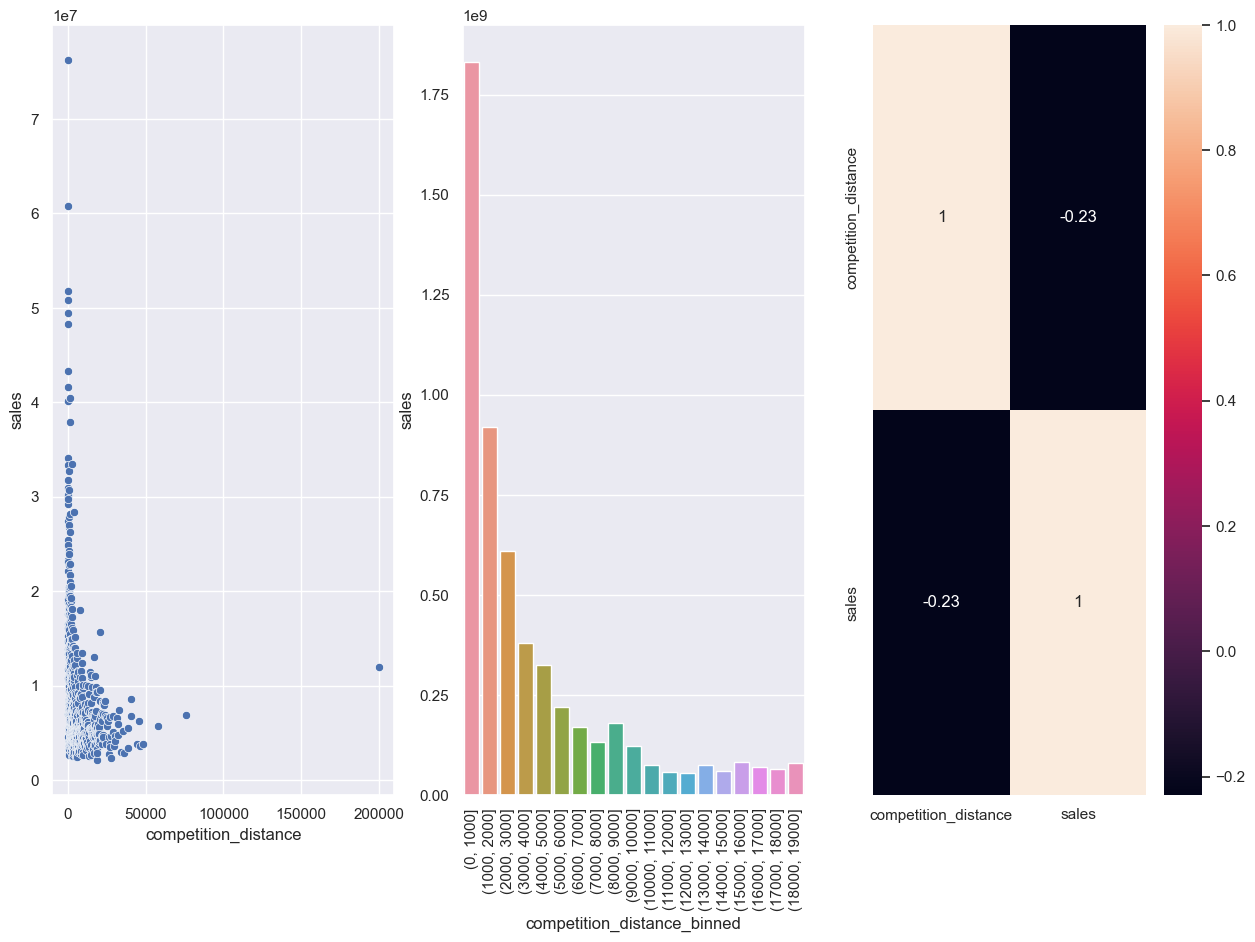

In [52]:
plt.figure(figsize=(15, 10))

# 1. verificar a distribuição das vendas em relação a distancia do competidor

aux1 = df4[['competition_distance', 'sales']].groupby(
    'competition_distance').sum().reset_index()

plt.subplot(1, 3, 1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1)

# 2. compararando o somatório de vendas por conjunto de competidores

plt.subplot(1, 3, 2)
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(
    aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby(
    'competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2)
plt.xticks(rotation=90)

# 3. correlação entre o valor de vendas, distância entre a loja e o competidor mais próximos

plt.subplot(1, 3, 3)
x = sns.heatmap(aux1.corr(method='pearson'), annot=True)

#### Hipótese 3: Lojas com competidores a mais tempo devem vender mais

- **Hipótese Falsa** ❌

- Lojas com competidores a mais tempo vendem menos ✅

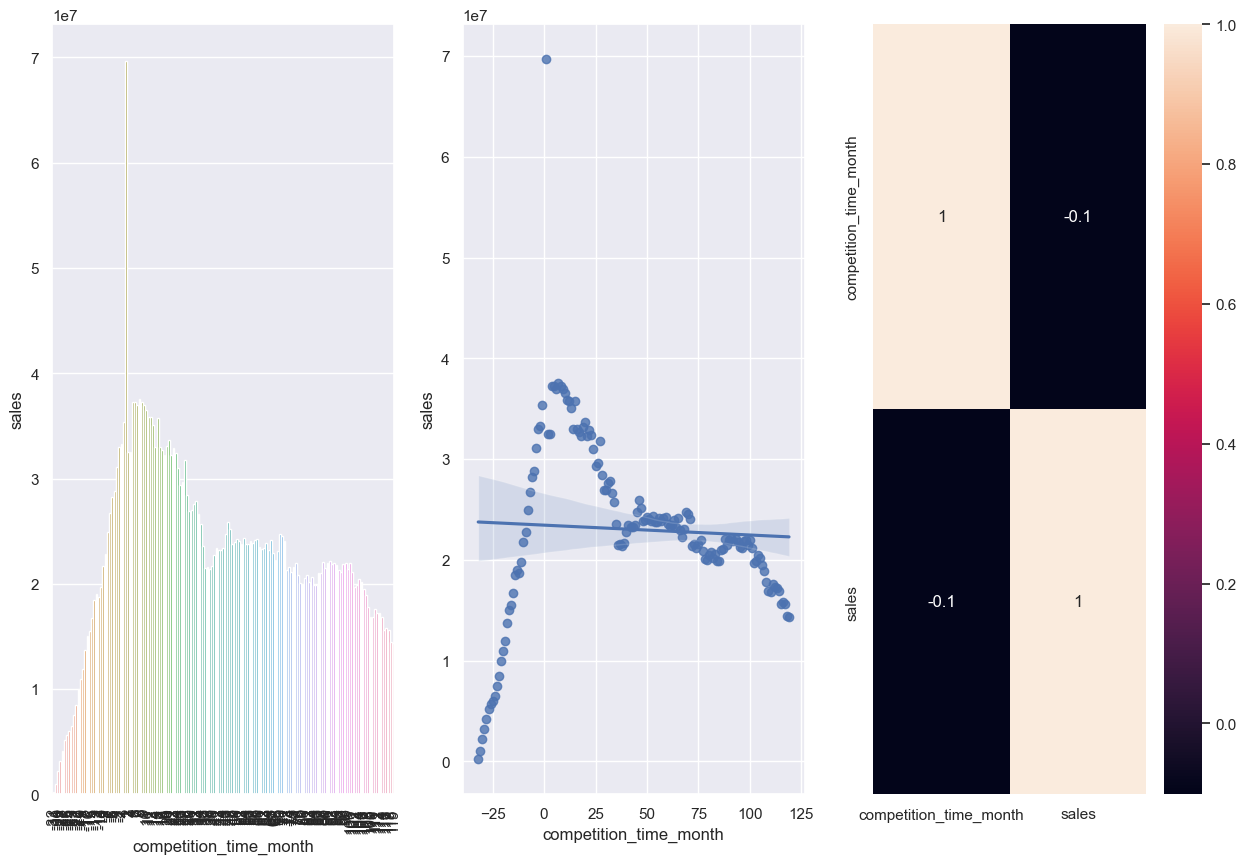

In [53]:
plt.figure(figsize=(15, 10))

# 1. comparando as vendas conforme os competidores abriam e iniciavam a competição

plt.subplot(1, 3, 1)

aux1 = df4[['competition_time_month', 'sales']].groupby(
    'competition_time_month').sum().reset_index()

# 1.1 filtrando os 120 primeiros meses de competição e tempo de competição diferente de zero
aux2 = aux1[(aux1['competition_time_month'] < 120) &
            (aux1['competition_time_month'] != 0)]


# 1.2 gráfico de barras
sns.barplot(x='competition_time_month', y='sales', data=aux2)
plt.xticks(rotation=90)

# 2. gráfico de tendência

# obs: tendência de crescimento das vendas em relação ao tempo de competição

plt.subplot(1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux2)

# 3. correlação entre o tempo decorrido de competição com o valor das vendas

plt.subplot(1, 3, 3)
x = sns.heatmap(aux1.corr(method='pearson'), annot=True)

**Observações:**

- 'competition_time_month' foi derivada da coluna 'date' (datas de vendas da Rossmann) e da coluna 'competition_since' (data que o competidor abriu)

- ou seja, ela representa a diferença em meses da data de venda registrada (Rossmann) da data que o competidor abriu (há quantos meses o competidor está ali)

- valores positivos: o competidor ja existia no local quando a Rossmann iniciou as vendas /  valores negativos: o competidor abriu depois de a loja da Rossmann ja ter iniciado suas vendas

- quanto mais o tempo de competição aumenta, mais as vendas da Rossmann vão caindo

**Observações:**

- o compartamento das vendas tanto decai quanto sobe ao longo do tempo


- o gráfico abaixo é de tendência linear e o comportamento das vendas não é linear, ou seja, esse gráfico não deve ser utilizado para gerar qualquer tipo de conclusão, e sim, somente para auxiliar na leitura do comportamento geral e entendimento de outros gráficos

#### Hipótese 4: Lojas com promoções ativas por mais tempo devem vender mais

- **Hipótese Falsa** ❌
- Lojas com promoções ativas por mais tempo vendem menos ✅ 

In [ ]:
aux1 = df4[['promo_time_week', 'sales']].groupby(
    'promo_time_week').sum().reset_index()

plt.figure(figsize=(15, 10))

# definindo duas linhas e três colunas

grid = gridspec.GridSpec(2, 3)

# 1. vendas com relação ao período de promoção extendida

plt.subplot(grid[0, 0])
aux2 = aux1[aux1['promo_time_week'] > 0]
sns.barplot(x='promo_time_week', y='sales', data=aux2)
plt.xticks(rotation=90)

# 1.1 verificando se tendência das vendas é crescente ou descrescente
plt.subplot(grid[0, 1])
sns.regplot(x='promo_time_week', y='sales', data=aux2)


# 2. vendas com relação ao período de promoção regular

plt.subplot(grid[1, 0])
aux3 = aux1[aux1['promo_time_week'] < 0]
sns.barplot(x='promo_time_week', y='sales', data=aux3)
plt.xticks(rotation=90)

# 2.1 verificando se tendência das vendas é crescente ou descrescente

plt.subplot(grid[1, 1])
sns.regplot(x='promo_time_week', y='sales', data=aux3)


# 3. verificando a correlação entre o tempo de promoção extendida e a quantiade de vendas
plt.subplot(grid[:, 2])
sns.heatmap(aux1.corr(method='pearson'), annot=True)

<AxesSubplot: >

**Observações:**

- promo_time_week: quanto tempo faz que uma promoção foi ativa

- período de promoção tradicional (promo) e extendido (promo2: quando a tradicional acaba)

- promo2_since_week: semana em que a promoção extendida começou (fim da tradicional)

- promo2_since_year: ano em que a promoção extendida começou (fim da tradicional)

- para calcular o tempo em que a promoção foi ativa foi feita, foi utilizada a coluna 'date' - a data em que a promoção extendida começou (fim da tradicional)- 

    - isso tem dois resultados: positivo e negativo
    - positivo:venda foi realizada no período promocional extendido
    - negativo:venda no período tradicional de promoções

#### Hipótese 6: Lojas com mais promoções consecutivas devem vender mais

- **Hipótese Falsa** ❌
- Lojas com mais promoções consecutivas vendem menos ✅

In [ ]:
# quantidade descrescente de vendas de acordo com o período de promoções

df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum(
).reset_index().sort_values(by='sales', ascending=True)

In [ ]:
# verificando o comportamento das vendas quando a loja está em promoção extendida

aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][[
    'year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

# verificando o comportamento das vendas quando a loja está apenas em promoção regular

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][[
    'year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

# adicionando legendas

ax.legend(labels=['Promo regular & extendida', 'Promo regular'])

#### Hipótese 7: Lojas abertas durante o feriado de natal devem vender mais

- **Hipótese Falsa** ❌
- Lojas abertas durante o feriado de natal vendem menos ✅

In [ ]:
plt.figure(figsize=(15, 10))

# 1.filtro removendo os dias regulares (sem feriados)

plt.subplot(1, 2, 1)

aux = df4[df4['state_holiday'] != 'regular_day']

# 1.1 checando vendas ao longo dos feriados

aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum(
).reset_index()

sns.barplot(x='state_holiday', y='sales', data=aux1)


# 2. checando venda dos feriados ao longo do tempo

plt.subplot(1, 2, 2)

aux2 = aux[['year', 'state_holiday', 'sales']].groupby(
    ['year', 'state_holiday']).sum().reset_index()

sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2)

#### Hipótese 8: Lojas devem vender mais ao longo dos anos

- **Hipótese Falsa** ❌
- Lojas vendem menos ao longo dos anos ✅

**Observação:** Só tem dados de 2015 até o mês de agosto.

In [ ]:
plt.figure(figsize=(15, 10))

# 1. checando vendas ao longo dos anos

plt.subplot(1, 3, 1)

aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

sns.barplot(x='year', y='sales', data=aux1)

# 2. checando tendência

plt.subplot(1, 3, 2)

sns.regplot(x='year', y='sales', data=aux1)

# 3. correlação

plt.subplot(1, 3, 3)

sns.heatmap(aux1.corr(method='pearson'), annot=True)

#### Hipótese 9: Lojas devem vender mais no segundo semestre do ano

- **Hipótese Falsa** ❌
- Lojas vendem menos no segundo semestre do ano ✅

In [ ]:
plt.figure(figsize=(15, 10))

# 1. checando vendas ao longo dos meses

plt.subplot(1, 3, 1)

aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

sns.barplot(x='month', y='sales', data=aux1)

# 2. checando tendência

plt.subplot(1, 3, 2)

sns.regplot(x='month', y='sales', data=aux1)

# 3. correlação

plt.subplot(1, 3, 3)

sns.heatmap(aux1.corr(method='pearson'), annot=True)

#### Hipótese 10: Lojas devem vender mais depois do dia 10 de cada mês

- **Hipótese Verdadeira** ✅
- Lojas vendem mais depois do dia 10 de cada mês ✅

In [ ]:
plt.figure(figsize=(15, 10))

# 1. checando vendas ao longo dos dias

plt.subplot(2, 2, 1)

aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

sns.barplot(x='day', y='sales', data=aux1)

# 2. checando tendência

plt.subplot(2, 2, 2)

sns.regplot(x='day', y='sales', data=aux1)

# 3. correlação

plt.subplot(2, 2, 3)

sns.heatmap(aux1.corr(method='pearson'), annot=True)

# 4. filtrando uma nova coluna para separar os dias antes e depois do dia 10

aux1['before_after'] = aux1['day'].apply(
    lambda x: 'before' if x <= 10 else 'after')

aux2 = aux1[['before_after', 'sales']].groupby(
    'before_after').sum().reset_index().sort_values(by='sales', ascending=True)

# 4.1 comparando as vendas antes e depois do dia 10

plt.subplot(2, 2, 4)

sns.barplot(x='before_after', y='sales', data=aux2)

#### Hipótese 11: Lojas devem vender menos nos finais de semana

- **Hipótese Verdadeira** ✅
- Lojas vendem menos nos finais de semana ✅

In [ ]:
plt.figure(figsize=(15, 10))

# 1. checando dias da semana em relação as vendas

plt.subplot(1, 3, 1)

aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

sns.barplot(x='day_of_week', y='sales', data=aux1)

# 2. checando tendência

plt.subplot(1, 3, 2)

sns.regplot(x='day_of_week', y='sales', data=aux1)

# 3. correlação

plt.subplot(1, 3, 3)

sns.heatmap(aux1.corr(method='pearson'), annot=True)

#### Hipótese 12: Lojas devem vender menos durante os feriados escolares

- **Hipótese Verdadeira** ✅
- Lojas vendem menos durante os feriados escolares ✅  **(exceto em Julho e Agosto)**

In [ ]:
plt.figure(figsize=(15, 10))

# 1. verificando o valor de vendas entre os dias normais e feriados escolares

plt.subplot(2, 1, 1)

aux1 = df4[['school_holiday', 'sales']].groupby(
    'school_holiday').sum().reset_index()

sns.barplot(x='school_holiday', y='sales', data=aux1)

# 2. verificando o valor de vendas entre os dias normais e feriados escolares ao longo do mês

plt.subplot(2, 1, 2)

aux2 = df4[['month', 'school_holiday', 'sales']].groupby(
    ['month', 'school_holiday']).sum().reset_index()

sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2)

#### Resumo das hipóteses

In [ ]:
tab = [
    ['Hypotesis', 'Conclusion', 'Relevance'],
    ['H1', 'False', 'Low'],
    ['H2', 'False', 'Medium'],
    ['H3', 'False', 'Medium'],
    ['H4', 'False', 'Low'],
    ['H5', '-', '-'],
    ['H6', 'False', 'Low'],
    ['H7', 'False', 'Medium'],
    ['H8', 'False', 'High'],
    ['H9', 'False', 'High'],
    ['H10', 'True', 'High'],
    ['H11', 'True', 'High'],
    ['H12', 'True', 'Low'],
]

print(tabulate(tab, headers='firstrow'))

### 9.3 Análise multivariada

#### 9.3.1 Atributos numéricos

In [ ]:
# analisando a correlação de dados numéricos

plt.figure(figsize=(20, 15))

correlacao_numericos = colunas_numericas.corr()

sns.heatmap(correlacao_numericos, annot=True)

plt.show()

#### 9.3.2 Atributos categóricos

In [ ]:
# selecionando somente dados categóricos

cat = df4.select_dtypes(include='object')

In [ ]:
# aplicando a função de Cramer v para analisar a correlação dos dados

result_1 = cramer_v(cat['state_holiday'], cat['state_holiday'])
result_2 = cramer_v(cat['state_holiday'], cat['store_type'])
result_3 = cramer_v(cat['state_holiday'], cat['assortment'])

result_4 = cramer_v(cat['store_type'], cat['state_holiday'])
result_5 = cramer_v(cat['store_type'], cat['store_type'])
result_6 = cramer_v(cat['store_type'], cat['assortment'])

result_7 = cramer_v(cat['assortment'], cat['state_holiday'])
result_8 = cramer_v(cat['assortment'], cat['store_type'])
result_9 = cramer_v(cat['assortment'], cat['assortment'])


# salvando em um dataset

tab_cramerv = pd.DataFrame({'state_holiday': [result_1, result_2, result_3],
                            'store_type': [result_4, result_5, result_6],
                            'assortment': [result_7, result_8, result_9]})


tab_cramerv = tab_cramerv.set_index(tab_cramerv.columns)


# verificando a correlação entre as variáveis categóricas

sns.heatmap(tab_cramerv, annot=True)

## 10. Preparação dos dados

In [ ]:
df5 = df4.copy()

### 10.1 Normalização

Após a observação das variáveis numéricas da EDA (9.1.2), foi visto que não há nenhuma variável com distribuição normal (Gaussiana). Por esse motivo, não será feita a etapa de normalização dessas variáveis. Em contrapartida, será feita a etapa de Rescaling, que é mais adequada para dados com distribuição não Gaussiana.

### 10.2 Rescaling

**Analisar outliers** (boxplot)
- Ver a possibilidade de usar o Robust Scaler


**Variáveis com natureza linear:**

- competition_distance
- year
- competition_time_month
- promo_time_week

In [ ]:
r = df5.select_dtypes(include=['int64', 'float64'])

- Checando outliers da coluna 'competition_distance' para ver se é necessário aplicar o RobustScaler

- Nas que não possuíam, foi usado o MinMaxScaler

In [ ]:
# sns.boxplot(df5['competition_distance'])

# sns.boxplot(df5['year'])

# sns.boxplot(df5['competition_time_month'])

# sns.boxplot(df5['promo_time_week'])

In [ ]:
rs = RobustScaler()

# 'competition_distance'
df5['competition_distance'] = rs.fit_transform(
    df5[['competition_distance']].values)

# 'competition_time_month'
df5['competition_time_month'] = rs.fit_transform(
    df5[['competition_time_month']].values)

mms = MinMaxScaler()

# 'promo_time_week'
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

# 'year'
df5['year'] = mms.fit_transform(df5[['year']].values)

### 10.3 Transformação

#### 10.3.1 Encoding

**Variáveis categóricas:**

- **state_holiday** ➞ one hot encoding
    - cria +4 colunas com as informações abaixo:
         - 'regular_day', 'public_holiday', 'easter_holiday', 'chrismas'
         - 1 = True, 0 = False
         
         
- **store_type** ➞ label encoding
    - substitui os itens abaixo em números:
        - a, b, c, d ➞  1, 2, 3 e 4
        
        
- **assortment** ➞ ordinal encoding
    - substitui os itens abaixo em números (ordinal)
        - basic, extra e extended ➞ 1, 2, 3

In [ ]:
# state_holiday

df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store_type

le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

# assortment

assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

#### 10.3.2 Transformação da variável resposta

In [ ]:
df5['sales'] = np.log1p(df5['sales'])

In [ ]:
sns.histplot(df5['sales'], bins=40, kde=True)

#### 10.3.3 Transformação de natureza

**Variáveis de natureza cíclica:**

- day
- day_of_week
- month
- week_of_year

In [ ]:
# day

df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2 * np.pi / 30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2 * np.pi / 30)))

# day_of_week

df5['day_of_week_sin'] = df5['day_of_week'].apply(
    lambda x: np.sin(x * (2 * np.pi / 7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(
    lambda x: np.cos(x * (2 * np.pi / 7)))

# month

df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2 * np.pi / 12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2 * np.pi / 12)))

# week_of_year

df5['week_of_year_sin'] = df5['week_of_year'].apply(
    lambda x: np.sin(x * (2 * np.pi / 12)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(
    lambda x: np.cos(x * (2 * np.pi / 12)))

## 11. Seleção de Features

In [ ]:
df6 = df5.copy()

### 11.1 Split do dataset original em treino e teste

In [ ]:
# quando colunas são derivadas de uma variável, a variável original deve ser apagada

cols_drop = ['week_of_year', 'day', 'month', 'day_of_week',
             'promo_since', 'competition_since', 'year_week']

df6 = df6.drop(cols_drop, axis=1)

In [ ]:
# verificando a data do primeiro dia das últimas 6 semanas (6 semanas * 7 dias = 42 dias)

df6[['store', 'date']].groupby('store').max().reset_index()[
    'date'][0] - datetime.timedelta(days=6*7)

**Observação**: como trata-se de um projeto de séries temporais, as linhas de treino e de teste não podem ser selecionadas aleatoriamente, pois podem estar dando dados futuros e passados para o modelo.

**Dados de treino**: todas as datas antes de 19/06/2015


**Dados de teste**: todas as datas iguais ou após o dia 19/06/2015 (6 últimas semanas)

In [ ]:
# separando features e target

# treino
X_train = df6[df6['date'] < '2015-06-19'].drop('sales', axis=1)
y_train = df6[df6['date'] < '2015-06-19'][['sales']]

# teste
X_test = df6[df6['date'] >= '2015-06-19'].drop('sales', axis=1)
y_test = df6[df6['date'] >= '2015-06-19'][['sales']]

In [ ]:
# verificando datas mínimas e máximas do X_treino e X_teste

print(f'Data mínima de treino: {X_train["date"].min()}')
print(f'Data máxima de treino: {X_train["date"].max()}')

print(f'Data mínima de teste: {X_test["date"].min()}')
print(f'Data máxima de teste: {X_test["date"].max()}')

### 11.2 Implementação do algoritmo Boruta para a seleção de features

In [ ]:
X_train_n = X_train.drop(['date'], axis=1).values
y_train_n = y_train.values.ravel()

In [ ]:
# 1. definindo o Random Forest Regressor
rf = RandomForestRegressor(n_estimators=5)

In [ ]:
# 2. definindo o boruta
# 2.1 deixar o estimator como automático para que o algoritmo escolha automaticamente os melhores parêmtros
# 2.2 verbose = 2 faz com que o algoritmo printe o processo

boruta = BorutaPy(rf, n_estimators=25, verbose=2, random_state=42)

In [ ]:
# 3. treinando o boruta
boruta.fit(X_train_n, y_train_n)

In [ ]:
# 4. salvando as colunas relevantes em uma lista

cols_selecionadas = boruta.suport_.tolist()

In [ ]:
X_train_fs = X_train.drop(['date'], axis=1)

# 5. melhores features do boruta
cols_selecionadas_boruta = X_train_fs.iloc[:,cols_selecionadas]

# 6. analisando quais colunas o boruta nao selecionou
cols_nao_selecionadas = np.setdiff1d(X_train_fs.columns,cols_selecionadas_boruta.columns)

In [ ]:
## 7. salvando as features

#cols_selecionadas_boruta = ['month_sin', 'week_of_year_sin']

#cols_nao_selecionadas =

## 12. Comparação de hipóteses do EDA e features do boruta

In [ ]:
# 1. hipóteses de features relevantes do EDA

tab

 hipótese 9: 'year'
 
 hipótese 10: 'month'
 
 hipótese 11:'day'
 
 hipótese 12: 'day_of_week'

In [ ]:
# 2. colulnas selecionadas pelo boruta

cols_selecionadas_boruta

In [ ]:
# dropar colunas do X_train, X_teste, y_train e y_test e deixar somente as colunas do boruta no dataset